In [1]:
%load_ext autoreload
%autoreload 2

import sys
if "../src" not in sys.path:
    sys.path.append("../src")

In [2]:
from datetime import datetime
from generation.generators import SATGraph, G2SATPolicy, train_reinforce
from generation.envs import G2SATEnv
from gnn_models.sage import SAGE
from solvers.pysat import PySAT
from torch import optim
from torch.utils.tensorboard.writer import SummaryWriter
import torch
import random


## Playing with graphs

In [3]:
g = SATGraph.from_template(SATGraph.sample_template(3, 9))


Clauses: [[1], [1], [2], [2], [2], [3], [-1], [-2], [-3]]
Valid merges: [(6, 8), (6, 9), (6, 10), (6, 11), (6, 13), (6, 14), (7, 8), (7, 9), (7, 10), (7, 11), (7, 13), (7, 14), (8, 11), (8, 12), (8, 14), (9, 11), (9, 12), (9, 14), (10, 11), (10, 12), (10, 14), (11, 12), (11, 13), (12, 13), (12, 14), (13, 14)]


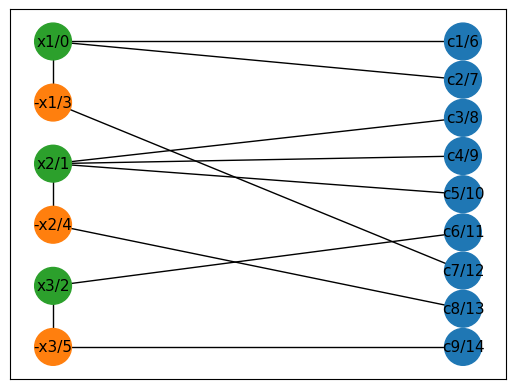

In [4]:
g.plot_nx()
print("Clauses:", g.to_clauses())
print("Valid merges:", g.get_valid_merges())


Clauses: [[1], [1, 2], [2], [2], [3], [-1], [-2], [-3]]
Valid merges: [(7, 10), (7, 13), (6, 8), (6, 9), (6, 10), (6, 12), (6, 13), (8, 10), (8, 11), (8, 13), (9, 10), (9, 11), (9, 13), (10, 11), (10, 12), (11, 12), (11, 13), (12, 13)]


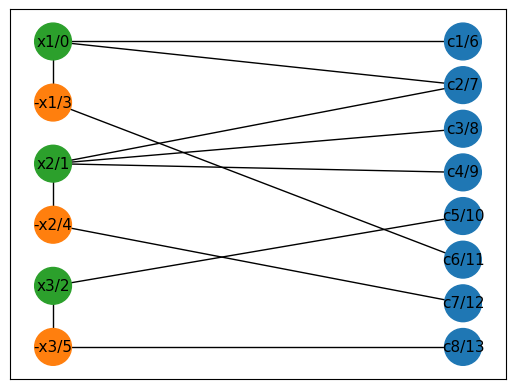

In [5]:
g.merge(*random.choice(g.get_valid_merges()))
g.plot_nx()
print("Clauses:", g.to_clauses())
print("Valid merges:", g.get_valid_merges())


Clauses: [[1, 2, -3], [1, 2], [2, 3, -1], [-2]]
Valid merges: []


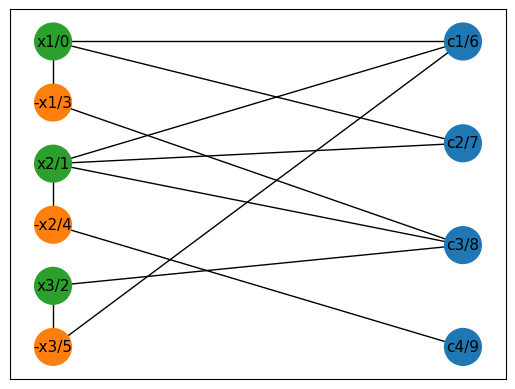

In [6]:
while not g.is_3sat():
    valid = g.get_valid_merges()
    if not valid:
        break
    g.merge(*random.choice(valid))

g.plot_nx()
print("Clauses:", g.to_clauses())
print("Valid merges:", g.get_valid_merges())


{'feasible': True,
 'time_cpu': 2.5410000000114508e-05,
 'restarts': 1,
 'conflicts': 0,
 'decisions': 7,
 'propagations': 7}

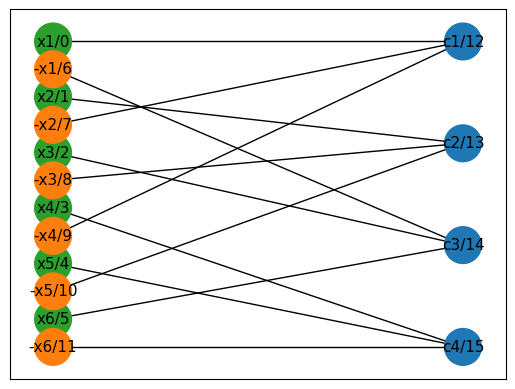

In [7]:
env = G2SATEnv(6, 4, PySAT("minisat22"), "decisions")
obs, _ = env.reset()

done = False
while not done:
    obs, _, done, _, info = env.step(random.choice(obs["valid_actions"]))
env.render()
info


## RL

In [97]:
env = G2SATEnv(10, 42, PySAT("minisat22"), "time_cpu", compress_observations=True)
model = SAGE(
    input_dim=1 if env.compress_observations else 3,
    feature_dim=32,
    hidden_dim=32,
    output_dim=32,
    num_embeddings=3 if env.compress_observations else None,
    num_layers=3,
)#.to('cuda')
policy = G2SATPolicy(env, model, random_state=42)


In [98]:
env.graph.sample_valid_merges(1000)

AttributeError: 'G2SATEnv' object has no attribute 'graph'

In [89]:
policy.generate()

SATGraph(node_type=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], edge_index=[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 8, 8, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 13, 14, 14, 15, 15, 15, 15, 15, 15, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19], [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 23, 28, 45, 27, 46, 24, 41, 31, 32, 38, 22, 26, 20, 25, 46, 36, 44, 38, 20, 37, 34, 35, 42, 47, 41, 29, 45, 26, 47, 28, 47, 44, 29, 39, 48, 24, 27, 33, 40, 49, 45,

In [106]:
%%prun

train_reinforce(
    policy,
    optimizer=optim.AdamW(model.parameters(), lr=3e-4),
    num_episodes=5,
)


Training:   0%|          | 0/5 [00:00<?, ?episodes/s]

         3799680 function calls (3789344 primitive calls) in 5.556 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  1246364    1.116    0.000    1.223    0.000 graph.py:157(have_overlapping_vars)
      419    1.082    0.003    2.473    0.006 graph.py:43(get_valid_merges)
     1242    0.916    0.001    0.916    0.001 {built-in method torch.as_tensor}
        5    0.704    0.141    0.704    0.141 {method 'run_backward' of 'torch._C._EngineBase' objects}
  1047513    0.124    0.000    0.124    0.000 {method 'append' of 'list' objects}
1253810/1252982    0.109    0.000    0.110    0.000 {built-in method builtins.len}
     2484    0.102    0.000    0.102    0.000 {method 'scatter_add_' of 'torch._C._TensorBase' objects}
        1    0.096    0.096    5.552    5.552 generators.py:62(train_reinforce)
     2484    0.095    0.000    0.095    0.000 {built-in method torch._C._nn.linear}
      208    0.090    0.000    0.090    0.000 g